### 다해상도
어떤 영상에서는 사람이 영상 전체를 덮을 정도로 크게 나타나기도 하고 반대로 보이지 않을 정도로 아주 작게 나타날 수 있다.  
이러한 다양한 상황에서 물체를 안정적으로 찾아내고 인식하는 것이 컴퓨터 비전의 궁극적인 목표 중의 하나이다.
이 문제를 해결하기 위해 고안된 기법중 하나가 영상 피라미드(image pyramid)이다.  
영상 피라미드는 여러 해상도의 동일한 이미지 영상으로 구성된다. 큰 해상도부터 작은 해상도까지 쌓아 올린 모양을 보고 피라미드라고 한다. 이를 다중 해상도(multi-resolution) 영상이라 부르기도 한다.  
이 구조는 거침과 세밀함(coarse to fine)처리 방식에서 강점을 보이기도 한다. 저해상도의 거친 영상에서 물체의 대략적인 위치와 모양을 찾아낸 후, 고해상도의 세밀한 영상에서 정확한 위치와 모양을 결정하는 접근 방법이다.  
피라미드는 샘플링 비율(sampling rate) r을 1/2로 설정해 영상을 절반으로 다운샘플링(down sampling)하는 작업을 반복해 만든다.(이와 반대로 영상의 해상도를 높이는 과정을 업샘플링(up sampling)이라고 한다.)  
아래는 피라미드 구성의 식이다.

$$
f_{k}(j,i)=f_{k-1}(\frac{j}{r},\frac{i}{r}), r=\frac{1}{2}, 1 \le k \le q
$$
q는 몇단계 까지 줄일 것인지를 정한다. 예를들어 1024 X 1024 영상이고 q=6이라면 512 X 512, 256 X 256, 128 X 128, 64 X 64, 32 X 32, 16 X 16과 같이 총 일곱 장의 영상으로 피라미드를 구성할 수 있다.

위 식은 단순하다는 측면에서 좋지만, 에일리어싱이 발생하는 문제를 안고 있다. 이러한 문제는 다운샘플링 과정에서 짝수 좌표의 화소는 100% 참여하는 반면 홀수 좌표의 화소는 0% 참여하기 때문에 발생한다. 참여하지 못하는 화소에도 무시할 수 없는 정보가 들어 있는 것이다.  
이러한 문제를 해결하기 위해 버트와 아델슨이 제안한 방식은 다운샘플링을 하기 전에 스무딩을 적용하는 것이다. 이 식은 다섯 화소의 가중치 곱의 합을 계산하는데, 가중치 역할을 하는 스무딩 커널 w 설계가 핵심이다.

$$
f_{k}(j,i)= \sum_{y=-2}^{2} \sum_{x=-2}^{2} f_{k-1}(\frac{j}{r}+y,\frac{i}{r}+x), r=\frac{1}{2}, 1 \le k \le q
$$

### 코드구현
먼저 간단한 다운 샘플링 부터 구현 해보자  
새로 만들어진 해상도의 각 픽셀은 원본의 2배의 위치에서 가져오는 방식으로 된다.

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt

def down_simple(img):
    out_h,out_w,c = img.shape
    out_h//=2
    out_w//=2
    down_img = np.zeros([out_h,out_w,c],dtype=np.uint8)
    for y in range(out_h):
        for x in range(out_w):
            down_img[y,x] = img[y*2,x*2]
    return down_img

사이즈가 16 X 16 아래부터는 형체가 거의 보이지 않으므로 16 X 16 까지만 다운 샘플링을 하도록 범위를 지정해줬다.

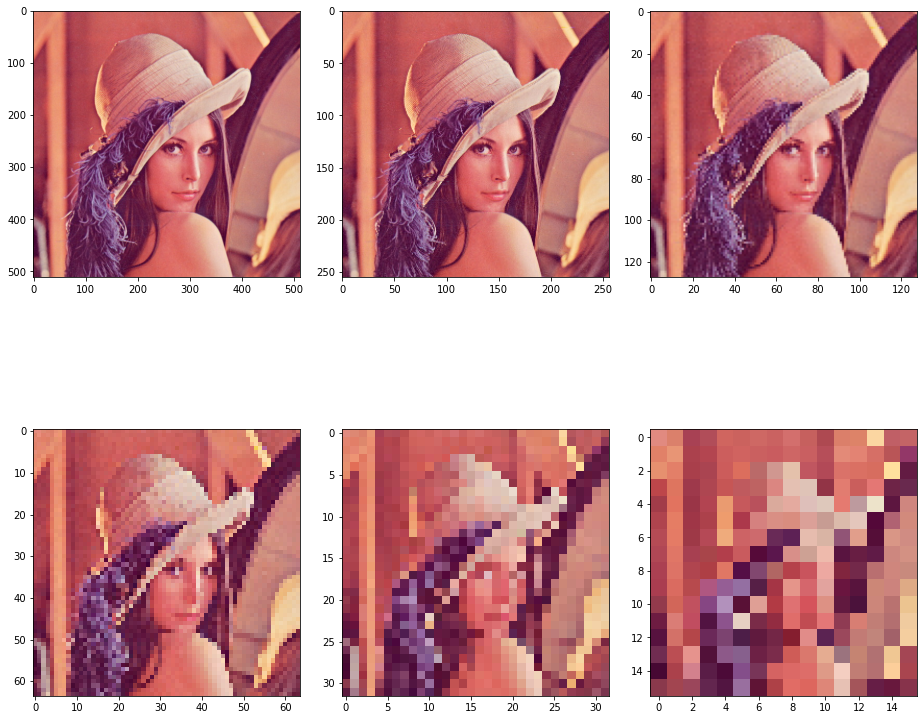

In [2]:
img = cv2.cvtColor(cv2.imread('./data/lena.jpg'),cv2.COLOR_BGR2RGB)

min_axis = np.minimum(img.shape[0],img.shape[1])
if np.log2(min_axis) > 4 :
    iteration = int(np.log2(min_axis)-4)
else:
    iteration = 1
    
pyramid = []
pyramid.append(img)

subplot_y = (iteration+1)//3 # subplot 지정, 원본도 plot 하기위해 +1, 한 행당 3개의 그림 plot. 
if (iteration+1) %3 >0: # 3으로 나눠떨어지지 않으면 행 추가
    subplot_y+=1

sub_num = subplot_y*100+31
fig = plt.figure(figsize=(13,13))
plt.subplot(sub_num)
plt.imshow(pyramid[0])

for i in range(iteration):
    pyramid.append(down_simple(pyramid[i]))
    plt.subplot(sub_num+i+1)
    plt.imshow(pyramid[i+1])

fig.tight_layout()
plt.show()

보는 바와 같이 계단현상이 엄청 심하다.  
이번에는 버트와 아델슨이 사용한 필터를 사용할 것이다.

In [3]:
smooed_kernel = np.array([[0.0025,0.0125,0.02,0.0125,0.0025],
                          [0.0125,0.0625,0.1,0.0625,0.0125],
                          [0.02,0.1,0.16,0.1,0.02],
                          [0.0125,0.0625,0.1,0.0625,0.0125],
                          [0.0025,0.0125,0.02,0.0125,0.0025]])

가우시안 커널과 값은 비슷하지만 미세하게 차이가 난다.

In [4]:
gaussian_filter_1d = cv2.getGaussianKernel(5,0)
gaussian_filter_2d = np.outer(gaussian_filter_1d, gaussian_filter_1d.transpose())
print(gaussian_filter_2d)

[[0.00390625 0.015625   0.0234375  0.015625   0.00390625]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.0234375  0.09375    0.140625   0.09375    0.0234375 ]
 [0.015625   0.0625     0.09375    0.0625     0.015625  ]
 [0.00390625 0.015625   0.0234375  0.015625   0.00390625]]


컨볼루션 연산을 거치면 해당 픽셀에는 가중치만큼의 값이 되어 있으므로 위의 simple버전에서 스무딩연산만 추가하면 된다.

In [5]:
def smoothing_down(img,kernel):
    smooed = cv2.filter2D(img,-1,kernel)
    out_h, out_w, c = img.shape
    out_h //= 2
    out_w //= 2
    down_img = np.zeros([out_h, out_w, c], dtype=np.uint8)
    for y in range(out_h):
        for x in range(out_w):
            down_img[y, x] = smooed[y * 2, x * 2]
    return down_img


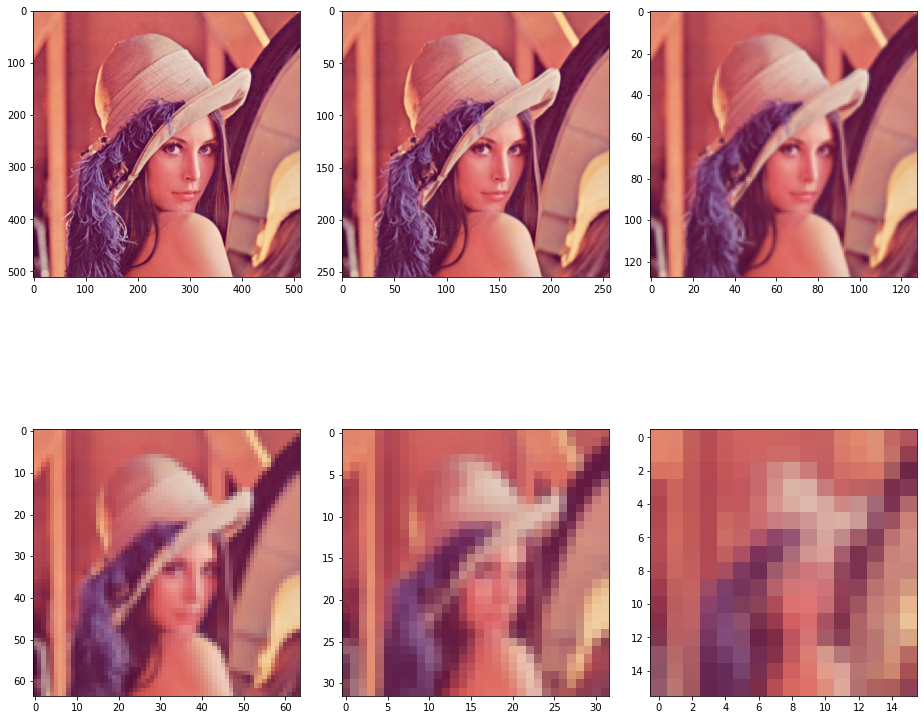

In [6]:
smooed_pyramid = []
smooed_pyramid.append(img)


fig = plt.figure(figsize=(13,13))
plt.subplot(sub_num)
plt.imshow(smooed_pyramid[0])

for i in range(iteration):
    smooed_pyramid.append(smoothing_down(smooed_pyramid[i],smooed_kernel))
    plt.subplot(sub_num+i+1)
    plt.imshow(smooed_pyramid[i+1])

fig.tight_layout()
plt.show()

아주 계단현상이 없다고 할 수는 없지만 확실히 이전보다 나아진것을 볼 수 있다.  
커널을 직접 만들지 않고 가우시안 블러를 바로 사용해도 된다.

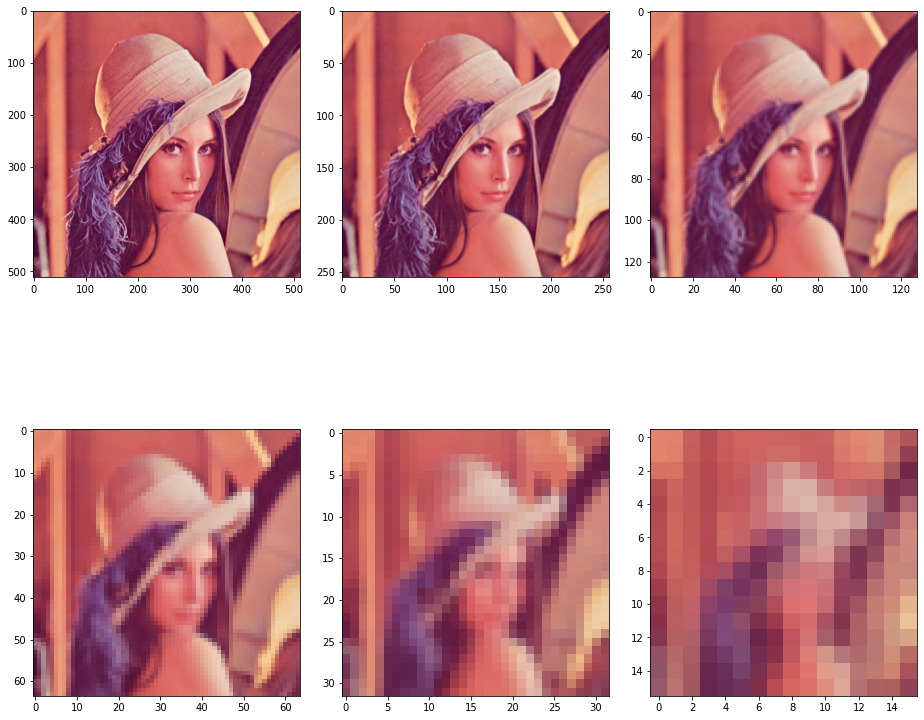

In [7]:
def gaussian_smoothing_down(img):
    smooed = cv2.GaussianBlur(img,(5,5),0)
    out_h, out_w, c = img.shape
    out_h //= 2
    out_w //= 2
    down_img = np.zeros([out_h, out_w, c], dtype=np.uint8)
    for y in range(out_h):
        for x in range(out_w):
            down_img[y, x] = smooed[y * 2, x * 2]
    return down_img

gaussian_smooed_pyramid = []
gaussian_smooed_pyramid.append(img)

fig = plt.figure(figsize=(13,13))
plt.subplot(sub_num)
plt.imshow(gaussian_smooed_pyramid[0])

for i in range(iteration):
    gaussian_smooed_pyramid.append(gaussian_smoothing_down(gaussian_smooed_pyramid[i]))
    plt.subplot(sub_num+i+1)
    plt.imshow(gaussian_smooed_pyramid[i+1])

fig.tight_layout()
plt.show()

opencv를 사용하게 되면 resize함수를 이용해 다운샘플링, 업샘플링을 수행하게 될것이다.  
resize의 interpolation method에도 여러 종류가 있다.  
nearst 방식은 가장 단순한 방식이고 area방식은 4x4 영역내의 값을 고려한다.

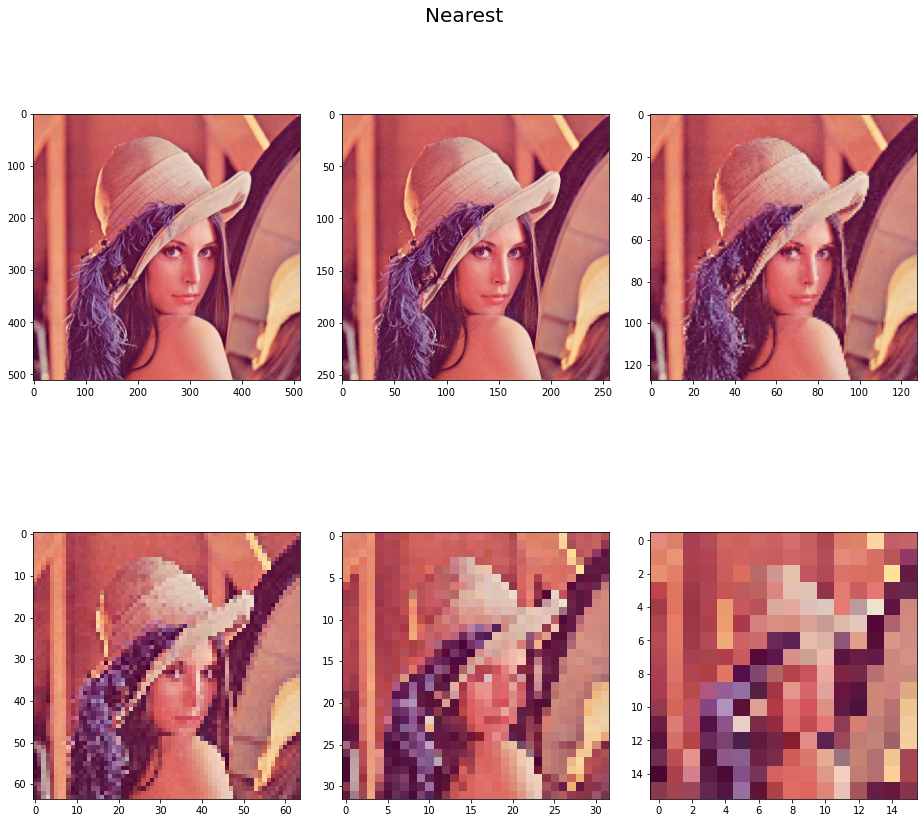

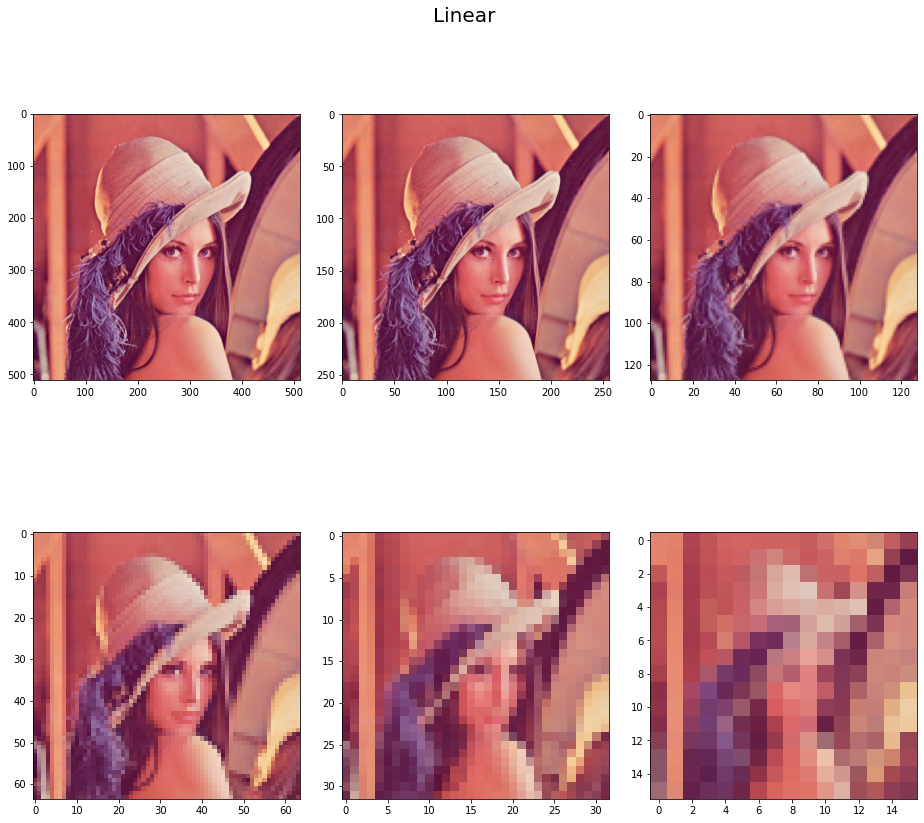

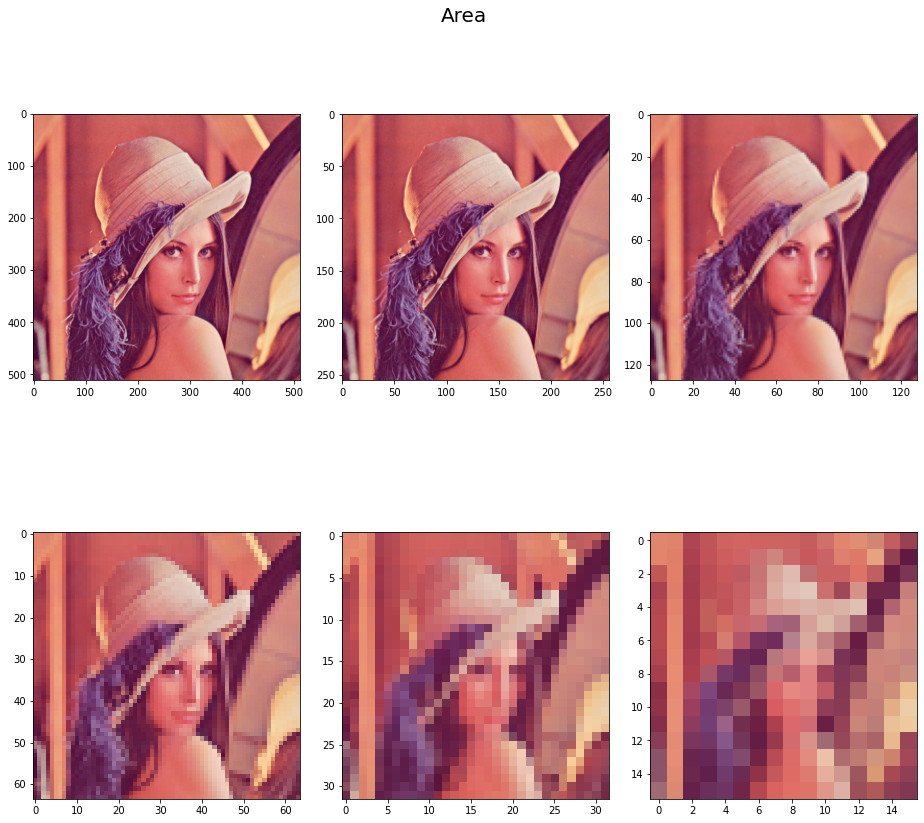

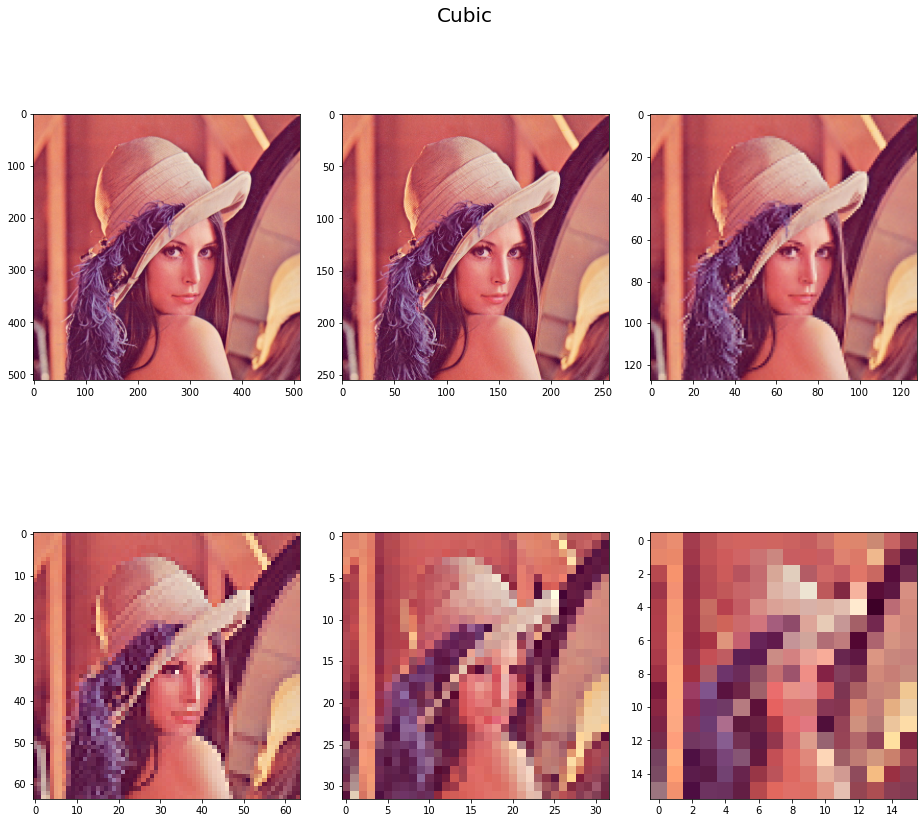

In [8]:
## opencv resize

# inter_nearest
inter_nearest_pyramid =[]
inter_nearest_pyramid.append(img)
fig = plt.figure(figsize=(13,13))
fig.suptitle("Nearest", fontsize=20)
plt.subplot(sub_num)
plt.imshow(inter_nearest_pyramid[0])
for i in range(iteration):
    inter_nearest_pyramid.append(cv2.resize(inter_nearest_pyramid[i],dsize=(0,0),fx=0.5,fy=0.5,interpolation=cv2.INTER_NEAREST))
    plt.subplot(sub_num + i + 1)
    plt.imshow(inter_nearest_pyramid[i + 1])

fig.tight_layout()
plt.show()
    
# inter_linear
inter_linear_pyramid =[]
inter_linear_pyramid.append(img)
fig = plt.figure(figsize=(13,13))
fig.suptitle("Linear", fontsize=20)
plt.subplot(sub_num)
plt.imshow(inter_linear_pyramid[0])
for i in range(iteration):
    inter_linear_pyramid.append(cv2.resize(inter_linear_pyramid[i],dsize=(0,0),fx=0.5,fy=0.5,interpolation=cv2.INTER_LINEAR))
    plt.subplot(sub_num + i + 1)
    plt.imshow(inter_linear_pyramid[i + 1])
fig.tight_layout()
plt.show()

# inter_area
inter_area_pyramid =[]
inter_area_pyramid.append(img)
fig = plt.figure(figsize=(13,13))
fig.suptitle("Area", fontsize=20)
plt.subplot(sub_num)
plt.imshow(inter_area_pyramid[0])
for i in range(iteration):
    inter_area_pyramid.append(cv2.resize(inter_area_pyramid[i],dsize=(0,0),fx=0.5,fy=0.5,interpolation=cv2.INTER_AREA))
    plt.subplot(sub_num + i + 1)
    plt.imshow(inter_area_pyramid[i + 1])
fig.tight_layout()
plt.show()

# inter_cubic
inter_cubic_pyramid =[]
inter_cubic_pyramid.append(img)
fig = plt.figure(figsize=(13,13))
fig.suptitle("Cubic", fontsize=20)
plt.subplot(sub_num)
plt.imshow(inter_cubic_pyramid[0])
for i in range(iteration):
    inter_cubic_pyramid.append(cv2.resize(inter_cubic_pyramid[i],dsize=(0,0),fx=0.5,fy=0.5,interpolation=cv2.INTER_CUBIC))
    plt.subplot(sub_num + i + 1)
    plt.imshow(inter_cubic_pyramid[i + 1])
fig.tight_layout()
plt.show()